# Predicting Insurance Claims filed by Travelling Agencies

In [1]:
# Importing all the required modules for the model building
import pandas as pd
import numpy as np
from scipy import *
from sklearn.preprocessing import *                   # For Encoding 
from sklearn.model_selection import *                 # For GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *                     
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# importing libraries for balancing the imbalanced class 
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from collections import Counter

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# Reading the dataset file 
df=pd.read_csv('travel insurance.csv',sep=',')
row,column=df.shape
print("The dataset has {} Rows and {} Columns".format(row,column))
print('')
cols=list(df.columns)
continous=list(set(df._get_numeric_data().columns)-{'Duration','Age'})
print("Columns : ",cols)
print("Continous Variables   : ",continous)
categorical=list(set(cols)-set(continous))
print("Categorical Variables : ",categorical)
# Duration and Age are categorical ( done in EDA part [Ayush_Project.ipynb] )
df_=df.copy()

The dataset has 63326 Rows and 11 Columns

Columns :  ['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Claim', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)', 'Gender', 'Age']
Continous Variables   :  ['Net Sales', 'Commision (in value)']
Categorical Variables :  ['Agency', 'Product Name', 'Claim', 'Duration', 'Age', 'Gender', 'Distribution Channel', 'Agency Type', 'Destination']


##Feature Engineering 
It includes :
* Encoding the DataFrame 
* Missing values Handling 
* Outliers Handling 

### Missing value and Outliers Handling 

In [4]:
# Imputing the missing values in column Gender with 'N'
df_['Gender']=df_['Gender'].fillna('N')

In [5]:
# Handling Outliers by removing the outliers
df_ = df_[df_.Age != 118]
df_ = df_[df_.Duration >=0]
df_.loc[df_['Net Sales'] == 0.0, 'Commision (in value)'] = 0
print("Now the dataset  has {} Rows and {} Columns".format(df_.shape[0],df_.shape[1]))
print("%d records deleted from the dataset"%(df.shape[0]-df_.shape[0]))
df_=df_.reset_index().drop(columns='index')
df1=df_.copy()

Now the dataset  has 62342 Rows and 11 Columns
984 records deleted from the dataset


### Encoding the DataFrame 

In [6]:
# Label Encoding
le=LabelEncoder()
le_df=pd.DataFrame()
for i in list(set(df_.columns)-set(df_._get_numeric_data().columns)):
  le_df[i]=le.fit_transform(df_[i])
for j in list(df_._get_numeric_data().columns):
  le_df[j]=df_[j]
print("Label Encoded dataset  has {} Rows and {} Columns".format(le_df.shape[0],le_df.shape[1]))

Label Encoded dataset  has 62342 Rows and 11 Columns


In [7]:
# To get the name of the values that corresponds to the lable after encoding
relation=dict()
for l in list(set(df_.columns)-set(df_._get_numeric_data().columns)):
  indx=[]
  for x in df_[l].unique():
    #print(x,' ',df_.index[df_[l] == x].tolist()[0])
    indx.append(df_.index[df_[l] == x].tolist()[0])
  dic=dict(zip(le_df.loc[indx][l].to_list(),df_.loc[indx][l].to_list()))
  relation[l]=dic
  #print(dic)

In [8]:
#OneHotEncoding
ohe=OneHotEncoder()
ohe_df=df_.copy()
for i in list(set(df_.columns)-set(df_._get_numeric_data().columns)-{'Claim'}):
  ohe_df = pd.get_dummies(ohe_df, columns=[i], prefix=[i] )
ohe_df=ohe_df.drop(columns='Claim')
print("One Hot Encoded dataset  has {} Rows and {} Columns".format(ohe_df.shape[0],ohe_df.shape[1]))

One Hot Encoded dataset  has 62342 Rows and 199 Columns


## Functions

In [9]:
# Function to print the result and ROC curve after the prediction 
def print_result(y_test,y_pred):
  print("Confusion Matrix       : \n" ,confusion_matrix(y_test,y_pred))
  print("Accuracy of Model      : ",accuracy_score(y_test, y_pred))
  print("Precision of Model     : ",precision_score(y_test, y_pred))
  print("Recall of Model        : " , recall_score(y_test, y_pred))
  print("F1 Score of Model      : " ,f1_score(y_test, y_pred))
  print("ROC_AUC score of Model : " ,roc_auc_score(y_test,y_pred))	
  fpr, tpr, thresholds = roc_curve(y_test,y_pred)
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)'% roc_auc_score(y_test,y_pred))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc='best')

In [10]:
# Funtion to print the details of training and testing data after train-test split
def print_input(X_train, X_test, y_train, y_test):
  print("TRAIN(X_train) Feature set        : ",len(X_train))
  print("TRAIN(y_train) Label Feature set  : ",len(y_train))
  print("TEST (X_test)  Feature set        : ",len(X_test))
  print("TEST (y_test)  Label set          : ",len(y_test))
  print("-------For Training Set--------\n")
  print(y_train['Claim'].value_counts())
  l_1,l_2= y_train['Claim'].value_counts()
  print("Class Label 0 is : ",(l_1/y_train.shape[0])*100,"%")
  print("Class Label 1 is : ",(l_2/y_train.shape[0])*100,"%")
  print("\n-------For Testing Set--------\n")
  print(y_test['Claim'].value_counts())
  l_1,l_2= y_test['Claim'].value_counts()
  print("Class Label 0 is : ",(l_1/y_test.shape[0])*100,"%")
  print("Class Label 1 is : ",(l_2/y_test.shape[0])*100,"%")

In [11]:
# Function to balance the imbalanced classes 
def balance(X_train,y_train,typ,s=0.3):
  if(typ.lower() == 'ros'):
    rus=RandomOverSampler(random_state=21)
    x_res, y_res = rus.fit_sample(X_train, y_train)
    print('Dataset shape after Random Over Sampling', Counter(y_res))
    print('After ROS the number of Rows Training set has are  : ', x_res.shape[0])
  elif(typ.lower() == 'rus' ):
    ros=RandomUnderSampler(random_state=21)
    x_res, y_res = ros.fit_sample(X_train, y_train)
    print('Dataset shape after Random Under Sampling', Counter(y_res))
    print('After RUS the number of Rows Training set has are : ', x_res.shape[0])
  elif(typ.lower() == 'adasyn'):
    ada=ADASYN(random_state=21, sampling_strategy=s, n_jobs=-1)
    x_res, y_res = ada.fit_sample(X_train, y_train)
    print('Dataset shape after ADASYN', Counter(y_res))
    print('After ADASYN the number of Rows Training set has are : ', x_res.shape[0])
  elif(typ.lower() == 'smote'):
    smo=SMOTE(random_state=21, sampling_strategy=s, n_jobs=-1)
    x_rs, y_rs = smo.fit_sample(X_train, y_train)
    tom=TomekLinks(random_state=21)
    x_res, y_res = tom.fit_sample(x_rs,y_rs)
    print('Dataset shape after SMOTE + Tomek Links', Counter(y_res))
    print('After SMOTE Tomek the number of Rows Training set has are : ', x_res.shape[0])
  return x_res, y_res


In [16]:
# Function to print precision , recall, Accuracy and F1 score
def calc(TP,TN,FP,FN):
  if(TP==0):
    TP=0.00000000000000001
  if(FP==0):
    FP=0.00000000000000001
  if(FN==0):
    FN=0.00000000000000001
  conf_mat=[[TN,FP],[FN,TP]]
  precision=(TP/(TP+FP))
  recall= (TP/(TP+FN))
  f1=((2*recall*precision)/(recall+precision))
  accuracy=((TP+TN)/(TP+TN+FP+FN))
  TPR=(TP/(TP+FN))
  FPR=(FP/(FP+TN))
  print("Confusion Matrix       : \n" ,conf_mat[0],'\n',conf_mat[1])
  print("Accuracy of Model      : ", accuracy)
  print("Precision of Model     : ", precision)
  print("Recall of Model        : ", recall)
  print("F1 Score of Model      : ", f1)

In [17]:
# Function to compute the value of TP, TN, FP, FN
def comp(y_test,y_pred):
  TP=0
  TN=0
  FP=0
  FN=0
  for i in range(0,len(y_pred)):
    if (int(y_test.iloc[i]) == 1 and y_pred[i] == 1):
      TP+=1
    elif (int(y_test.iloc[i]) == 1 and y_pred[i] == 0 ):
      FN+=1
    elif (int(y_test.iloc[i]) == 0 and y_pred[i] == 1 ):
      FP+=1
    elif (int(y_test.iloc[i]) == 0 and y_pred[i] == 0 ):
      TN+=1
  print("{0} {1} {2} {3}".format(TP,TN,FP,FN))
  calc(TP,TN,FP,FN)

In [18]:
# Funtion to get the predicted value via probability 
def thresh(y_thresh,val=0.5):
  y_pred=[]
  for i in range(0,len(y_thresh)):
    if(y_thresh[i][0] >= val):
      y_pred.append(0)
    else:
      y_pred.append(1)
  y_pred=np.array(y_pred)
  return y_pred


In [20]:
# Function to Compare all the four buckets ( TP, TN, FP, FN) of the top 10% imp features
def comp_feat(X_test,y_test,y_pred,f=0):
  new=X_test.copy()
  new=new.reset_index()
  new=new.drop(columns='index')
  new['Actual']=y_test.values
  new['Predicted']=y_pred
  for i in range(0,len(new)):
    if   (int(new.iloc[i]['Actual']) == 1 and int(new.iloc[i]['Predicted']) == 1 ):
      new.loc[i,'TP'] = 1
    elif (int(new.iloc[i]['Actual']) == 1 and int(new.iloc[i]['Predicted']) == 0 ):
      new.loc[i,'FN'] = 1
    elif (int(new.iloc[i]['Actual']) == 0 and int(new.iloc[i]['Predicted']) == 1 ):
      new.loc[i,'FP'] = 1
    elif (int(new.iloc[i]['Actual']) == 0 and int(new.iloc[i]['Predicted']) == 0 ):
      new.loc[i,'TN'] = 1
  if (f==0):
    new=new.fillna(0)
  return(new)  

In [21]:
#Function to print the reasoning behind every prediction
def reason(df,h):
  l=[]
  i=0
  while(len(l)<6):
    n=['Age','Gender_N']
    if(h[i] not in n):
      l.append(h[i])
    i+=1
  contt=['Duration','Net Sales','Commision (in value)']
  for j in range(0,len(df)):
    nn=[]
    more=[]
    less=[]
    c=d=e=0
    for k in l:
      if (k in contt):
        if (df.loc[j][k] >= df[k].mean()):
          more.append(k)
        elif (df.loc[j][k] < df[k].mean()):
          less.append(k)
      elif (int(df.loc[j][k]) == 1):
        nn.append(k)
    s = ', '.join(nn).replace('_',' was found to be ')
    if (len(more) == 2):
      s_ =' and '.join(more) + ' value was large'
    elif (len(more) == 3) :
      s_ ='{}, {} and {} value was large'.format(more[0],more[1],more[2])
    elif (len(more) == 1) :
      s_ = ''.join(more) + ' value was large'
    else : 
      s_=''
    if (len(less) == 2):
      s__ =' and '.join(less) + ' value was small'
    elif (len(less) == 3) :
      s__ ='{}, {} and {} value was small'.format(less[0],less[1],less[2])
    elif (len(less) == 1) :
      s__ = ''.join(less) + ' value was small'
    else :
      s__=''
    if (len(nn) !=0 and len(more) != 0 and len(less) != 0):
      st = s + ' while ' + s_ + ' & ' + s__
    elif (len(nn) !=0 and len(more) != 0 and len(less) == 0):
      st = s + ' while ' + s_
    elif (len(nn) !=0 and len(more) == 0 and len(less) != 0):
      st = s + ' while ' + s__ 
    elif (len(nn) ==0 and len(more) != 0 and len(less) != 0):
      st = s_ + ' & ' + s__ 
    elif (len(nn) ==0 and len(more) != 0 and len(less) == 0):
      st = s_ 
    elif (len(nn) ==0 and len(more) == 0 and len(less) != 0):
      st = s__
    elif (len(nn) !=0 and len(more) == 0 and len(less) == 0):
      st = s
    df.loc[j, 'Reasoning'] = st 
  return(df)

In [23]:
# Tagert variable 
target = pd.DataFrame(le_df['Claim'])
le_df=le_df.drop(columns='Claim')

# MODEL TRAINING
Training the Machine Learning Model after balancing the imbalanced class

In [24]:
#Splitting the dataset into trainng and testing data and then balancing it using the following techniques:
# The model used is Random Forest Classifier with hyperparameter tuning at a threshold of 0.6 on one hot encoded dataset.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(ohe_df,target,test_size = 0.25, random_state = 21, stratify = target)
print_input(X_train, X_test, y_train, y_test)
# calling balance() function
X_u_train, y_u_train = balance(X_train, y_train.values.ravel(),'rus')  #RandomUnderSampling
X_o_train, y_o_train = balance(X_train, y_train.values.ravel(),'ros')  #RandomOverSampling
X_s_train, y_s_train = balance(X_train, y_train.values.ravel(),'smote',0.5)  #Smote + Tomek Links
X_a_train, y_a_train = balance(X_train, y_train.values.ravel(),'adasyn',0.5) #ADASYN

TRAIN(X_train) Feature set        :  46756
TRAIN(y_train) Label Feature set  :  46756
TEST (X_test)  Feature set        :  15586
TEST (y_test)  Label set          :  15586
-------For Training Set--------

0    46068
1      688
Name: Claim, dtype: int64
Class Label 0 is :  98.52853109761314 %
Class Label 1 is :  1.4714689023868595 %

-------For Testing Set--------

0    15357
1      229
Name: Claim, dtype: int64
Class Label 0 is :  98.53073270884127 %
Class Label 1 is :  1.4692672911587321 %
Dataset shape after Random Under Sampling Counter({0: 688, 1: 688})
After RUS the number of Rows Training set has are :  1376
Dataset shape after Random Over Sampling Counter({0: 46068, 1: 46068})
After ROS the number of Rows Training set has are  :  92136


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Dataset shape after SMOTE + Tomek Links Counter({0: 45752, 1: 23034})
After SMOTE Tomek the number of Rows Training set has are :  68786
Dataset shape after ADASYN Counter({0: 46068, 1: 22899})
After ADASYN the number of Rows Training set has are :  68967


In [26]:
# Tuning the hyperparameters for getting better results.
# The parameters passed in Random forest Classifier are in the param_grid
clf_dt = RandomForestClassifier()
param_grid = {
   'max_leaf_nodes': [ 40,50 ],
   'class_weight' : ['balanced'],
   'criterion' :['gini','entropy'] ,
   'max_depth' : [ 30, 50, 100 ],
   'min_samples_split': [ 2, 3, 4],
   'random_state': [42]
    }

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=50, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Confusion Matrix       : 
 [[12423  2934]
 [   67   162]]
Accuracy of Model      :  0.8074554087001155
Precision of Model     :  0.05232558139534884
Recall of Model        :  0.7074235807860262
F1 Score of Model      :  0.09744360902255639
ROC_AUC score of Model :  0.7581853203793386


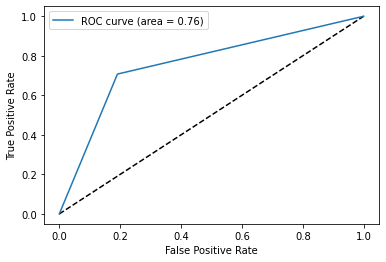

In [27]:
# Using GridSearchCV for hyperparameter tuning
CV_dt = GridSearchCV(estimator=clf_dt, param_grid=param_grid, cv= 3)
CV_dt.fit(X_u_train, y_u_train)
clf_best_dt = CV_dt.best_estimator_
print(clf_best_dt)
y_pred = clf_best_dt.predict(X_test)
print_result(y_test=y_test,y_pred=y_pred)

# Threshold
Chaning the thresholding from 0.50-0.95 to find the most appropriate result

In [28]:
x=np.linspace(0.5,0.95,10) # making a list of numbers with difference of 0.05
x

array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [29]:
# Computing the perdiction probability 
y_prob = clf_best_dt.predict_proba(X_test)
y_prob

array([[0.73957504, 0.26042496],
       [0.74620203, 0.25379797],
       [0.7210524 , 0.2789476 ],
       ...,
       [0.74425203, 0.25574797],
       [0.16310187, 0.83689813],
       [0.79374904, 0.20625096]])

In [30]:
# Getting the reslts after changing the threshold 
# calling thresh(y_prob,i) function  which returns prediction matrix (y_pred)
# calling comp(y_test,y_pred) which prints the result (confusion matrix, accuracy, precision, recall, F1 score)
for i in x:
  print("\n Threshold => ",i,'\n')
  comp(y_test,thresh(y_prob,i))
#Most optimum results if obtained at threshold of 0.65 


 Threshold =>  0.5 

162 12423 2934 67
Confusion Matrix       : 
 [12423, 2934] 
 [67, 162]
Accuracy of Model      :  0.8074554087001155
Precision of Model     :  0.05232558139534884
Recall of Model        :  0.7074235807860262
F1 Score of Model      :  0.09744360902255639

 Threshold =>  0.55 

168 11862 3495 61
Confusion Matrix       : 
 [11862, 3495] 
 [61, 168]
Accuracy of Model      :  0.7718465289362249
Precision of Model     :  0.04586404586404586
Recall of Model        :  0.7336244541484717
F1 Score of Model      :  0.08633093525179855

 Threshold =>  0.6 

178 11247 4110 51
Confusion Matrix       : 
 [11247, 4110] 
 [51, 178]
Accuracy of Model      :  0.7330296419863981
Precision of Model     :  0.04151119402985075
Recall of Model        :  0.777292576419214
F1 Score of Model      :  0.0788133717068851

 Threshold =>  0.65 

188 10530 4827 41
Confusion Matrix       : 
 [10530, 4827] 
 [41, 188]
Accuracy of Model      :  0.6876684203772616
Precision of Model     :  0.037487537

In [31]:
# Results when threshold is 0.65
comp(y_test,thresh(y_prob,0.65))

188 10530 4827 41
Confusion Matrix       : 
 [10530, 4827] 
 [41, 188]
Accuracy of Model      :  0.6876684203772616
Precision of Model     :  0.03748753738783649
Recall of Model        :  0.8209606986899564
F1 Score of Model      :  0.07170099160945843


In [32]:
# Results when threshold is 0.60
comp(y_test,thresh(y_prob,0.60))

178 11247 4110 51
Confusion Matrix       : 
 [11247, 4110] 
 [51, 178]
Accuracy of Model      :  0.7330296419863981
Precision of Model     :  0.04151119402985075
Recall of Model        :  0.777292576419214
F1 Score of Model      :  0.0788133717068851


# Feature Importance 
Feature Importance  is done to know the contribution of each feature to the model. 

Here, only top 10% features are represented.

This is done to find the reason behind the prediction and for explaining the model 

In [33]:
# Creating a dataframe containing the features contributing top 10% in the model prediction and the corresponding percentage they've been contributing.
hyp=pd.DataFrame({'Percent' : clf_best_dt.feature_importances_ , 'Top 10% Features' : ohe_df.columns}).sort_values(by='Percent',ascending=False)
hyp[:19]

,Percent,Top 10% Features
1,0.122166,Net Sales
6,0.111741,Agency_C2B
2,0.098575,Commision (in value)
0,0.084843,Duration
47,0.065087,Gender_N
169,0.056063,Destination_SINGAPORE
3,0.049930,Age
51,0.042693,Agency Type_Travel Agency
11,0.037840,Agency_EPX
50,0.034486,Agency Type_Airlines


In [34]:
h=hyp['Top 10% Features'][0:19].to_list()

# Comparing Feature Importance for each TP, TN, FP, FN
It is to infer that how much a feature contribute to a particular bucket [ TP, TN, FP, FN ]. 

In [35]:
# calling comp_feat(X_test,y_test,y_pred) which returns a dataframe that has the computed values for each bucket
new_df=comp_feat(X_test,y_test,y_pred)

In [36]:
# Appending the columns for true positve, true negative, false positive and false negative with actual and predicted values for the comparison of features 
n=['TP','TN','FP','FN','Actual','Predicted']
for i in n:
  h.append(i)
new_df=new_df[h]


In [37]:
new_df

,Net Sales,Agency_C2B,Commision (in value),Duration,Gender_N,Destination_SINGAPORE,Age,Agency Type_Travel Agency,Agency_EPX,Agency Type_Airlines,Product Name_Cancellation Plan,Product Name_Basic Plan,Product Name_Bronze Plan,Gender_F,Product Name_Silver Plan,Product Name_2 way Comprehensive Plan,Agency_JZI,Product Name_Annual Silver Plan,Destination_CHINA,TP,TN,FP,FN,Actual,Predicted
0,20.0,0,0.00,21,1,0,34,1,1,0,0,0,0,0,0,1,0,0,1,0.0,1.0,0.0,0.0,0,0
1,24.0,0,0.00,47,1,0,36,1,1,0,0,0,0,0,0,1,0,0,0,0.0,1.0,0.0,0.0,0,0
2,-59.4,0,35.64,61,1,0,60,1,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0,0
3,80.0,0,0.00,63,1,0,36,1,1,0,1,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0,0
4,28.0,0,0.00,79,1,0,36,1,1,0,1,0,0,0,0,0,0,0,1,0.0,1.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15581,29.0,0,0.00,77,1,0,36,1,1,0,0,0,0,0,0,1,0,0,0,0.0,1.0,0.0,0.0,0,0
15582,15.0,0,0.00,4,1,0,36,1,1,0,1,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0,0
15583,26.0,0,9.10,40,0,0,44,0,0,1,0,1,0,0,0,0,1,0,1,0.0,1.0,0.0,0.0,0,0
15584,72.0,1,18.00,35,0,1,39,0,0,1,0,0,0,1,1,0,0,0,0,0.0,0.0,1.0,0.0,0,1


# Reasoning 
 It is done to give the reasoning behind the particular prediction by the model

In [40]:
# Calling function reason(df,h) which returns a dataframe that has a appended column named 'Reasoning'
df_res=reason(new_df,h)
df_res.head(2)

,Net Sales,Agency_C2B,Commision (in value),Duration,Gender_N,Destination_SINGAPORE,Age,Agency Type_Travel Agency,Agency_EPX,Agency Type_Airlines,Product Name_Cancellation Plan,Product Name_Basic Plan,Product Name_Bronze Plan,Gender_F,Product Name_Silver Plan,Product Name_2 way Comprehensive Plan,Agency_JZI,Product Name_Annual Silver Plan,Destination_CHINA,TP,TN,FP,FN,Actual,Predicted,Reasoning
0,20.0,0,0.0,21,1,0,34,1,1,0,0,0,0,0,0,1,0,0,1,0.0,1.0,0.0,0.0,0,0,Agency Type was found to be Travel Agency whil...
1,24.0,0,0.0,47,1,0,36,1,1,0,0,0,0,0,0,1,0,0,0,0.0,1.0,0.0,0.0,0,0,Agency Type was found to be Travel Agency whil...


In [41]:
df_res[df_res['Actual'] == 1]

,Net Sales,Agency_C2B,Commision (in value),Duration,Gender_N,Destination_SINGAPORE,Age,Agency Type_Travel Agency,Agency_EPX,Agency Type_Airlines,Product Name_Cancellation Plan,Product Name_Basic Plan,Product Name_Bronze Plan,Gender_F,Product Name_Silver Plan,Product Name_2 way Comprehensive Plan,Agency_JZI,Product Name_Annual Silver Plan,Destination_CHINA,TP,TN,FP,FN,Actual,Predicted,Reasoning
67,432.00,1,108.00,367,0,1,52,0,0,1,0,0,0,0,0,0,0,1,0,1.0,0.0,0.0,0.0,1,1,"Agency was found to be C2B, Destination was fo..."
115,62.25,1,15.56,11,0,1,33,0,0,1,0,0,0,0,1,0,0,0,0,1.0,0.0,0.0,0.0,1,1,"Agency was found to be C2B, Destination was fo..."
149,39.00,1,9.75,70,0,1,36,0,0,1,0,0,0,1,1,0,0,0,0,1.0,0.0,0.0,0.0,1,1,"Agency was found to be C2B, Destination was fo..."
207,252.85,1,63.21,413,0,1,31,0,0,1,0,0,0,1,0,0,0,1,0,1.0,0.0,0.0,0.0,1,1,"Agency was found to be C2B, Destination was fo..."
236,29.50,1,7.38,11,0,1,33,0,0,1,0,0,1,0,0,0,0,0,0,1.0,0.0,0.0,0.0,1,1,"Agency was found to be C2B, Destination was fo..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15345,26.50,1,6.63,52,0,1,74,0,0,1,0,0,1,0,0,0,0,0,0,1.0,0.0,0.0,0.0,1,1,"Agency was found to be C2B, Destination was fo..."
15425,27.00,1,6.75,10,0,1,23,0,0,1,0,0,1,0,0,0,0,0,0,1.0,0.0,0.0,0.0,1,1,"Agency was found to be C2B, Destination was fo..."
15433,22.10,1,5.53,31,0,1,24,0,0,1,0,0,1,1,0,0,0,0,0,1.0,0.0,0.0,0.0,1,1,"Agency was found to be C2B, Destination was fo..."
15459,252.85,1,63.21,367,0,1,45,0,0,1,0,0,0,0,0,0,0,1,0,1.0,0.0,0.0,0.0,1,1,"Agency was found to be C2B, Destination was fo..."


In [42]:
print(df_res[['Predicted','Reasoning']])

       Predicted                                          Reasoning
0              0  Agency Type was found to be Travel Agency whil...
1              0  Agency Type was found to be Travel Agency whil...
2              0  Agency Type was found to be Travel Agency whil...
3              0  Agency Type was found to be Travel Agency whil...
4              0  Agency Type was found to be Travel Agency whil...
...          ...                                                ...
15581          0  Agency Type was found to be Travel Agency whil...
15582          0  Agency Type was found to be Travel Agency whil...
15583          0  Commision (in value) value was large & Net Sal...
15584          1  Agency was found to be C2B, Destination was fo...
15585          0  Agency Type was found to be Travel Agency whil...

[15586 rows x 2 columns]


In [43]:
print(df_res[['Actual', 'Predicted', 'Reasoning']][0:15].to_string())

    Actual  Predicted                                                                                                                                            Reasoning
0        0          0                                         Agency Type was found to be Travel Agency while Net Sales, Commision (in value) and Duration value was small
1        0          0                                         Agency Type was found to be Travel Agency while Net Sales, Commision (in value) and Duration value was small
2        0          0                        Agency Type was found to be Travel Agency while Commision (in value) and Duration value was large & Net Sales value was small
3        0          0                        Agency Type was found to be Travel Agency while Net Sales and Duration value was large & Commision (in value) value was small
4        0          0                        Agency Type was found to be Travel Agency while Duration value was large & Net Sales and Commision (

In [44]:
print(df_res[df_res['TP'] == 1][['Actual', 'Predicted', 'Reasoning']][0:15].to_string())

     Actual  Predicted                                                                                                                                              Reasoning
67        1          1                   Agency was found to be C2B, Destination was found to be SINGAPORE while Net Sales, Commision (in value) and Duration value was large
115       1          1  Agency was found to be C2B, Destination was found to be SINGAPORE while Net Sales and Commision (in value) value was large & Duration value was small
149       1          1  Agency was found to be C2B, Destination was found to be SINGAPORE while Commision (in value) and Duration value was large & Net Sales value was small
207       1          1                   Agency was found to be C2B, Destination was found to be SINGAPORE while Net Sales, Commision (in value) and Duration value was large
236       1          1                   Agency was found to be C2B, Destination was found to be SINGAPORE while Net Sales, Commis

In [45]:
len(df_res.Reasoning.unique())

30

In [46]:
df_res.Reasoning.unique()

array(['Agency Type was found to be Travel Agency while Net Sales, Commision (in value) and Duration value was small',
       'Agency Type was found to be Travel Agency while Commision (in value) and Duration value was large & Net Sales value was small',
       'Agency Type was found to be Travel Agency while Net Sales and Duration value was large & Commision (in value) value was small',
       'Agency Type was found to be Travel Agency while Duration value was large & Net Sales and Commision (in value) value was small',
       'Commision (in value) value was large & Net Sales and Duration value was small',
       'Agency Type was found to be Travel Agency while Net Sales value was large & Commision (in value) and Duration value was small',
       'Destination was found to be SINGAPORE, Agency Type was found to be Travel Agency while Net Sales, Commision (in value) and Duration value was small',
       'Net Sales, Commision (in value) and Duration value was small',
       'Agency Type 

In [47]:
df_res.groupby('Reasoning').sum()[['Predicted','Actual','TP','TN','FP','FN']]

,Predicted,Actual,TP,TN,FP,FN
Reasoning,,,,,,
Agency Type was found to be Travel Agency while Commision (in value) and Duration value was large & Net Sales value was small,33,0,0.0,275.0,33.0,0.0
Agency Type was found to be Travel Agency while Commision (in value) value was large & Net Sales and Duration value was small,75,8,3.0,766.0,72.0,5.0
Agency Type was found to be Travel Agency while Duration value was large & Net Sales and Commision (in value) value was small,29,9,0.0,1346.0,29.0,9.0
Agency Type was found to be Travel Agency while Net Sales and Commision (in value) value was large & Duration value was small,354,11,6.0,256.0,348.0,5.0
Agency Type was found to be Travel Agency while Net Sales and Duration value was large & Commision (in value) value was small,117,8,4.0,625.0,113.0,4.0
Agency Type was found to be Travel Agency while Net Sales value was large & Commision (in value) and Duration value was small,52,13,2.0,1250.0,50.0,11.0
"Agency Type was found to be Travel Agency while Net Sales, Commision (in value) and Duration value was large",305,9,9.0,96.0,296.0,0.0
"Agency Type was found to be Travel Agency while Net Sales, Commision (in value) and Duration value was small",15,21,0.0,4814.0,15.0,21.0
"Agency was found to be C2B, Destination was found to be SINGAPORE while Commision (in value) and Duration value was large & Net Sales value was small",18,1,1.0,0.0,17.0,0.0


In [48]:
a=df_res.groupby('Reasoning')

In [49]:
a['Predicted'].value_counts()

Reasoning                                                                                                                                                             Predicted
Agency Type was found to be Travel Agency while Commision (in value) and Duration value was large & Net Sales value was small                                         0             275
                                                                                                                                                                      1              33
Agency Type was found to be Travel Agency while Commision (in value) value was large & Net Sales and Duration value was small                                         0             771
                                                                                                                                                                      1              75
Agency Type was found to be Travel Agency while Duration value was large & Net Sales and

In [50]:
a['Actual'].value_counts()

Reasoning                                                                                                                                                             Actual
Agency Type was found to be Travel Agency while Commision (in value) and Duration value was large & Net Sales value was small                                         0          308
Agency Type was found to be Travel Agency while Commision (in value) value was large & Net Sales and Duration value was small                                         0          838
                                                                                                                                                                      1            8
Agency Type was found to be Travel Agency while Duration value was large & Net Sales and Commision (in value) value was small                                         0         1375
                                                                                                       

In [51]:
df_res.groupby('Reasoning').count()['Predicted']

Reasoning
Agency Type was found to be Travel Agency while Commision (in value) and Duration value was large & Net Sales value was small                                            308
Agency Type was found to be Travel Agency while Commision (in value) value was large & Net Sales and Duration value was small                                            846
Agency Type was found to be Travel Agency while Duration value was large & Net Sales and Commision (in value) value was small                                           1384
Agency Type was found to be Travel Agency while Net Sales and Commision (in value) value was large & Duration value was small                                            615
Agency Type was found to be Travel Agency while Net Sales and Duration value was large & Commision (in value) value was small                                            746
Agency Type was found to be Travel Agency while Net Sales value was large & Commision (in value) and Duration value was small